In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob

### 이미지 로드

In [2]:
def read_image_file(fpath, target_height=400, target_width=300):
    content = tf.io.read_file(fpath)
    image = tf.image.decode_image(content)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    return image

In [3]:
fpaths = glob.glob("../data/Wconcept_*")
datasets = tf.data.Dataset.from_tensor_slices(fpaths)
datasets = datasets.map(read_image_file)

### 모형 생성

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K

In [5]:
# 입력 레이어
inputs = Input(shape=(400,300,3))

# preprocessing
prep_inputs = preprocess_input(inputs)

# embedding
embedding_output = VGG16(include_top=False)(prep_inputs)

# post-processing
output = GlobalAveragePooling2D()(embedding_output)
norm_output = K.l2_normalize(output, axis=-1)

model = Model(inputs, norm_output)

In [6]:
%%time
outputs = model.predict(datasets.batch(64), verbose=2)

6/6 - 44s
CPU times: user 10min 50s, sys: 30.7 s, total: 11min 21s
Wall time: 52.8 s


### 텐서보드에 올리기

In [15]:
df = pd.DataFrame(outputs,index=fpaths)

In [8]:
import os
from tensorboard.plugins import projector

log_dir = "../embedding"
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, "metadata.tsv"), 'w') as f:
    for fpath in df.index:
        f.write(f"{fpath}\n")
weights = tf.Variable(df.values)

checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

### 각 아이템에 대한 가장 유사한 아이템

In [9]:
def image_displayer(fpath):
    content = tf.io.read_file(fpath)
    image = tf.image.decode_image(content)
    plt.imshow(image)
    plt.show()
    
    
def image_displayer_n(fpaths):
    plt.figure(figsize=(15,5))
    for i in range(len(fpaths)):
        plt.subplot(1,len(fpaths),i+1)
        content = tf.io.read_file(fpaths[i])
        image = tf.image.decode_image(content)
        plt.imshow(image)
    plt.show()

In [10]:
rec_dic = {}
for idx, row in df.iterrows():
    rec_dic[idx] = df.dot(row).nlargest(5).index.tolist()

In [11]:
import random

given item


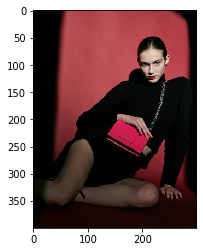

similar item


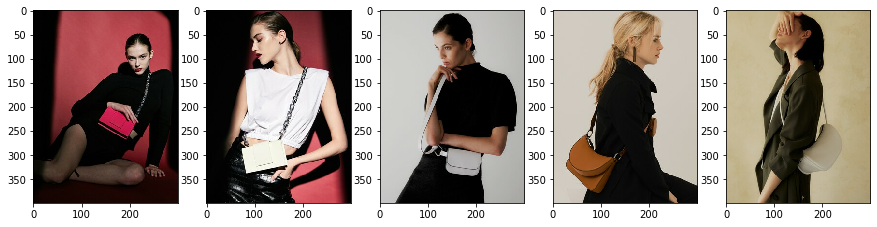

In [12]:
target_item = random.sample(rec_dic.keys(), k=1)[0]
print("given item")
image_displayer(target_item)
print("similar item")
image_displayer_n(rec_dic[target_item])

### 브랜드 내의 유사도

In [17]:
meta = pd.read_excel('../data/Wconcept.xlsx')

df.index = [name.split('/')[-1].strip(".jpg") for name in df.index]

givenchy = df.loc[meta.loc[meta['Brand name'] == 'GIVENCHY', 'Image']]

In [18]:
from scipy.spatial.distance import euclidean, pdist, squareform, cdist

dm = pdist(givenchy, lambda u, v: u@v)
dist_df = pd.DataFrame(squareform(dm))
print(f"similiarity among givenchy: {dist_df.mean().mean():.2f}")

dm = pdist(df, lambda u, v: u@v)
dist_df = pd.DataFrame(squareform(dm))
print(f"similiarity among all: {dist_df.mean().mean():.2f}")

similiarity among givenchy: 0.63
similiarity among all: 0.51
